In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist

In [2]:
# Generate 'orange peel' data n(-1)=n(+1)=100, n=200 x(-1) normally
# multivariate distributed N(mu=(0,0), sigma=diag(1/4, 1/4) diagonal matrix
# x(+1) normally multivariate distributed N(mu=(0,0), sigma=diag(4, 4) diagonal matrix

In [3]:
# Generating 2-variate data, member of group x(+1)
np.random.seed(2727)
sigma_p = np.array([[4, 0], [0, 4]])
Mp = np.linalg.cholesky(sigma_p).T  # Cholesky square root
Zp = np.random.normal(size=(2, 100))  # 2 rows, 100 columns
Xp = (Mp @ Zp).T
Xp1 = Xp[:, 0]
Xp2 = Xp[:, 1]

In [4]:
# Generating 2-variate data, member of group x(-1)
sigma_n = np.array([[0.25, 0], [0, 0.25]])
Mn = np.linalg.cholesky(sigma_n).T  # Cholesky square root
Zn = np.random.normal(size=(2, 100))  # 2 rows, 100 columns
Xn = (Mn @ Zn).T
Xn1 = Xn[:, 0]
Xn2 = Xn[:, 1]

In [5]:
# Aggregating data
X1 = np.concatenate([Xp1, Xn1])
X2 = np.concatenate([Xp2, Xn2])
X = np.column_stack([X2, X1])

In [6]:
# Generating indicator variable
yp = np.ones((100, 1))
yn = -np.ones((100, 1))
Y = np.vstack([yp, yn])

In [7]:
OrangePeel = np.column_stack([X2, X1])

In [8]:
'''
# This custom_rbf_kernel_1 should give the stationary Gaussian kernel with an anisotropic radial basis on p.507 of the book.
# However, it takes a lot of time to run and the result is not very different. For simplicity purpose, it is not used.
def custom_rbf_kernel_1(X, Y):
    # Calculate pairwise differences
    pairwise_dists = cdist(X, Y, 'euclidean')
    
    # Initialize empty kernel matrix
    K = np.zeros_like(pairwise_dists)
    
    # Calculate anisotropic Gaussian kernel for each pair of distances
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            diff = X[i] - Y[j]
            K[i, j] = np.exp(-0.5 * diff.T @ RB @ diff)
    
    return K
'''

"\n# This custom_rbf_kernel_1 should give the stationary Gaussian kernel with an anisotropic radial basis on p.507 of the book.\n# However, it takes a lot of time to run and the result is not very different. For simplicity purpose, it is not used.\ndef custom_rbf_kernel_1(X, Y):\n    # Calculate pairwise differences\n    pairwise_dists = cdist(X, Y, 'euclidean')\n    \n    # Initialize empty kernel matrix\n    K = np.zeros_like(pairwise_dists)\n    \n    # Calculate anisotropic Gaussian kernel for each pair of distances\n    for i in range(X.shape[0]):\n        for j in range(Y.shape[0]):\n            diff = X[i] - Y[j]\n            K[i, j] = np.exp(-0.5 * diff.T @ RB @ diff)\n    \n    return K\n"

In [9]:
# This custom_rbf_kernel_2 gives a simplified version of the stationary Gaussian kernel with an anisotropic radial basis.
# The simplicity comes from taking the mean of RB. The "rbf" kernel from the sklearn package can be used instead.

# Compute Radial Basis (RB)
r = 0.5  # parameter r (anisotropic Gaussian kernel). Note that if r = 0.2 in the R code, r = 0.8 in the Python code.
RB = inv(np.cov(X.T)) / (r ** 2)
gamma_value = 1 / (np.mean(RB) * 2)

def custom_rbf_kernel_2(X, Y=None):
    return rbf_kernel(X, Y, gamma=gamma_value)

In [10]:
# Initialize the SVC model with the anisotropic gaussian kernel
svc_model = SVC(C=20/200, kernel= custom_rbf_kernel_2, probability=True)

# Fit the SVC model
svc_model.fit(OrangePeel, Y.ravel())

# Perform 4-fold cross-validation
cv_scores = cross_val_score(svc_model, OrangePeel, Y.ravel(), cv=4)
mean_cv_score = np.mean(cv_scores)

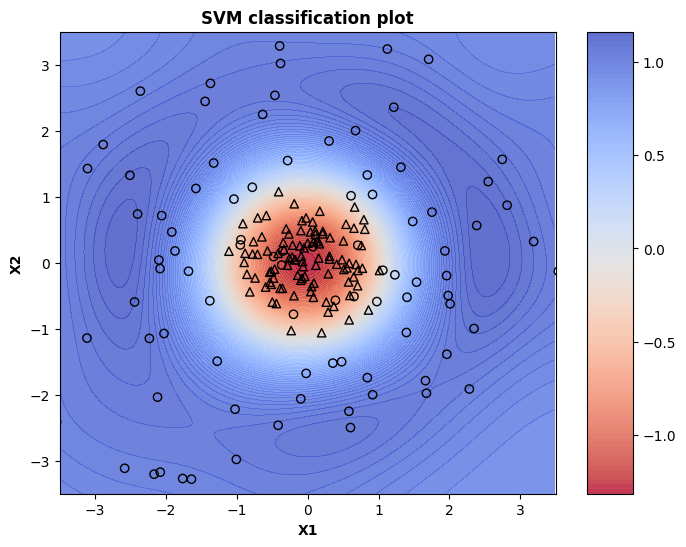

In [11]:
# Plotting
xx, yy = np.meshgrid(np.arange(-3.5, 3.5, 0.02),
                     np.arange(-3.5, 3.5, 0.02))

Z = svc_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
contourf_plot = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.8, levels=np.linspace(Z.min(), Z.max(), 100))

scatter_1 = plt.scatter(OrangePeel[Y.ravel() == 1, 0], OrangePeel[Y.ravel() == 1, 1], facecolors='none', edgecolors='black', marker='o', label='Class 1')
scatter_2 = plt.scatter(OrangePeel[Y.ravel() == -1, 0], OrangePeel[Y.ravel() == -1, 1], facecolors='none', edgecolors='black', marker='^', label='Class -1')

plt.xlim(-3.5, 3.5), plt.ylim(-3.5, 3.5)
plt.xlabel('X1', fontweight='bold'), plt.ylabel('X2', fontweight='bold'), plt.title('SVM classification plot', fontweight='bold')

colorbar = plt.colorbar(contourf_plot, aspect=10)
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])


plt.show()